# May 17, 2023: Nonlinear 1D model: modular network: ARNI inference

In [1]:
import csv
import os
import pickle
import random
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp 
from scipy.spatial.distance import pdist, cdist, squareform
from scipy import stats
import tvb
import networkx as nx
import copy
import matlab.engine
from itertools import product
from tqdm import tqdm

sys.path.append("/usr/local/MATLAB/R2022b/bin/matlab")

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_estimation')
month_dir = f"{proj_dir}/nb/apr23"
bdmodels_dir = f"{proj_dir}/helpers/bdmodels"
networks_dir = f"{proj_dir}/helpers/networks"
results_dir = f"{proj_dir}/results"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
import helpers.functions.network_utils as nw_utils
import helpers.functions.plotting_utils as plot_utils
import helpers.functions.time_series_simulation_utils as ts_sim_utils
import helpers.functions.fc_utils as fc_utils
import helpers.inference.ARNI as arni

## network construction

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

args.SEEDS = [100, 50, 75]
args.num_rois = np.array([5, 5, 5])
args.density = np.array([0.5, 0.3, 0.5])
args.scale = 1
args.group_label = ['A', 'B', 'C']
args.module_parts = [[2, 2, 1], [2, 3, 3, 2], [1, 2, 2]]
mod_prt_sum = [np.sum(m) for m in args.module_parts]
args.module_parts = [
    [int(nrois*prt/m) for prt in mod]
    for m, mod, nrois in zip(mod_prt_sum, args.module_parts, args.num_rois)
]
args.module_ps = [
    [[0.2, 0.2, 0.2], [0.2, 0.2, 0.2], [0.2, 0.2, 0.2]],
    [[0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2], [0.2, 0.2, 0.2, 0.2]],
    [[0.2, 0.2, 0.2], [0.2, 0.2, 0.2], [0.2, 0.2, 0.2]],
] 

In [3]:
args.num_networks = 1
args.num_modules = len(args.num_rois)
args.networks = [
    [
        ARGS() 
        for _ in range(args.num_modules)
    ] 
    for _ in range(args.num_networks)
]
idx_network = -1

idx_network += 1
for idx_module in range(args.num_modules):
    module = ARGS()
    module.name = 'watts strogatz'
    module.graph_generator = nx.watts_strogatz_graph
    module.params = [{'n':args.num_rois[idx_module], 'k':5, 'p':0.75, 'seed':int(args.SEEDS[idx_module])}]
    args.networks[idx_network][idx_module] = module

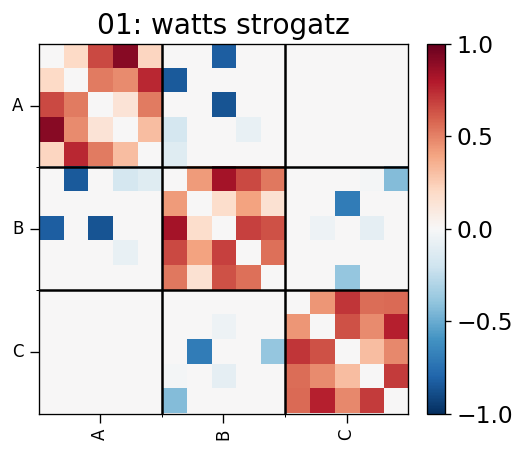

In [4]:
networks = []
for idx_network in range(args.num_networks):    
    (
        network, 
        roi_labels,
    ) = nw_utils.generate_connectivity_matrix(args, network=idx_network)
    networks.append(network)

args = plot_utils.create_matrix_ticks(args)
args.cmap = mpl.colormaps['RdBu_r'] #cmr.iceburn # mpl.colormaps['Oranges']
plot_utils.display_networks(args, networks)

# args.num_rois = args.num_rois.sum(axis=0)
args.num_subjs = len(networks)
args.num_sigmas = 5
args.num_runs = 50

In [5]:
sp.io.savemat(
    f"{networks_dir}/networks_numrois_{args.num_rois}.mat",
    dict(networks=networks),
)

## time series simulation

In [6]:
args.tspan = [0, 100]
args.delta_t = 0.1

args.sigmas = np.linspace(start=0.0, stop=1.0, num=10, endpoint=False)
args.sigmas

# version 1: with stimulus
stimulus = np.concatenate(
    [
        np.random.rand(args.num_rois[0],1),
        np.zeros((args.num_rois[1],1)),
        np.zeros((args.num_rois[2],1)),  
    ],
    axis=0,
)
args.num_rois = args.num_rois.sum(axis=0)
in_dict = {}
# in_dict['Kij'] = networks[0]
in_dict['k'] = 1.0
in_dict['A'] = matlab.double(1.0 * np.ones(shape=(args.num_rois,1)))
in_dict['B'] = 0.75
in_dict['C'] = 1.0
in_dict['Iamp'] = 1.0
in_dict['tau'] = 15.0
in_dict['T'] = 30.0
in_dict['tspan'] = matlab.double(args.tspan)
in_dict['teval'] = matlab.double(
    np.arange(args.tspan[0], args.tspan[-1], args.delta_t)
)
in_dict['s'] = matlab.double(stimulus)
# in_dict['sigma'] = 0.0

# version 2: without stimulus
# args.num_rois = args.num_rois.sum(axis=0)
# stimulus = np.zeros((args.num_rois, 1))
# in_dict = {}
# # in_dict['Kij'] = networks[0]
# in_dict['k'] = 1.0
# in_dict['A'] = matlab.double(1.0 * np.ones(shape=(args.num_rois,1)))
# in_dict['B'] = 0.75
# in_dict['C'] = 1.0
# in_dict['Iamp'] = 1.0
# in_dict['tau'] = 15.0
# in_dict['T'] = 30.0
# in_dict['tspan'] = matlab.double(args.tspan)
# in_dict['teval'] = matlab.double(
#     np.arange(args.tspan[0], args.tspan[-1], args.delta_t)
# )
# in_dict['s'] = matlab.double(stimulus)
# in_dict['sigma'] = 0.0

In [7]:
eng = matlab.engine.start_matlab()
model_path = f"{bdmodels_dir}"
model = eng.simulate_Nonlinear_1D_SDE_model
(
    in_dicts, out_dicts
) = ts_sim_utils.simulate_time_series(
    args, in_dict, networks,
    eng, model_path, model, n=1,
)
eng.quit()

100%|██████████| 5/5 [01:58<00:00, 23.80s/it]


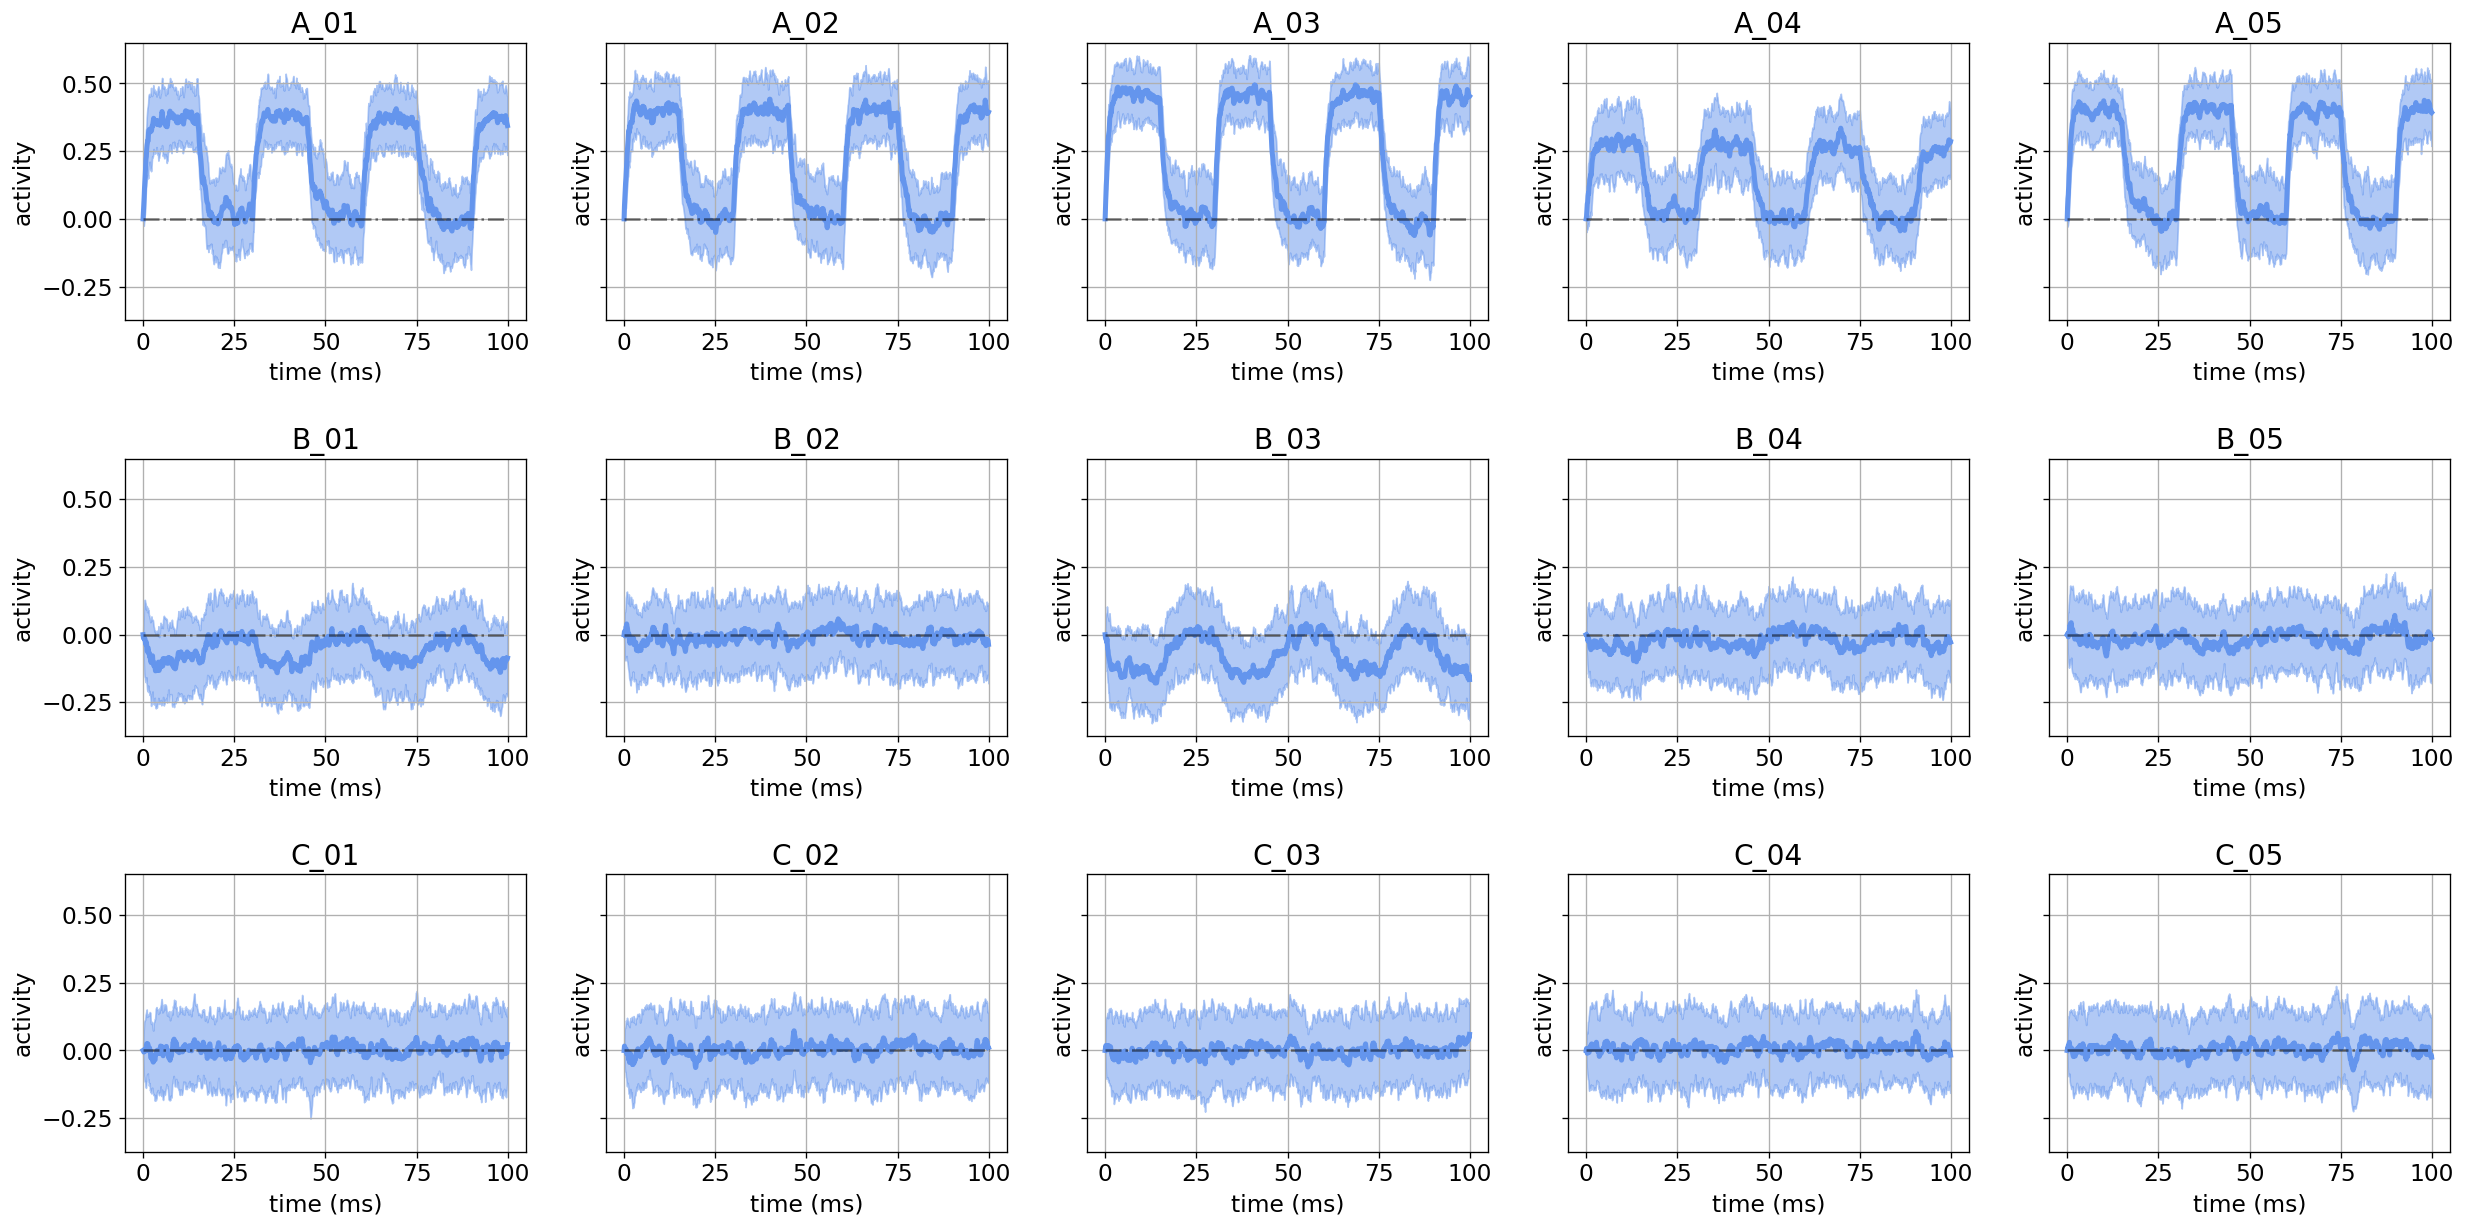

In [8]:
idx_subj, idx_sigma = 0, 2
args.subplot_layout = 'row-col'
plot_utils.plot_roi_time_series(
    args, 
    out_dicts[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"], #[f"run{8:02}"],
    roi_labels,
)

# plt.figure()
# args.cmap = mpl.colormaps['RdBu_r'] #cmr.iceburn # mpl.colormaps['Oranges']
# plt.imshow(
#     fcs_avg[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"], 
#     cmap=args.cmap)
# plt.colorbar()
# plt.title('fc')

## functional connectivity

100%|██████████| 5/5 [00:00<00:00, 61.36it/s]


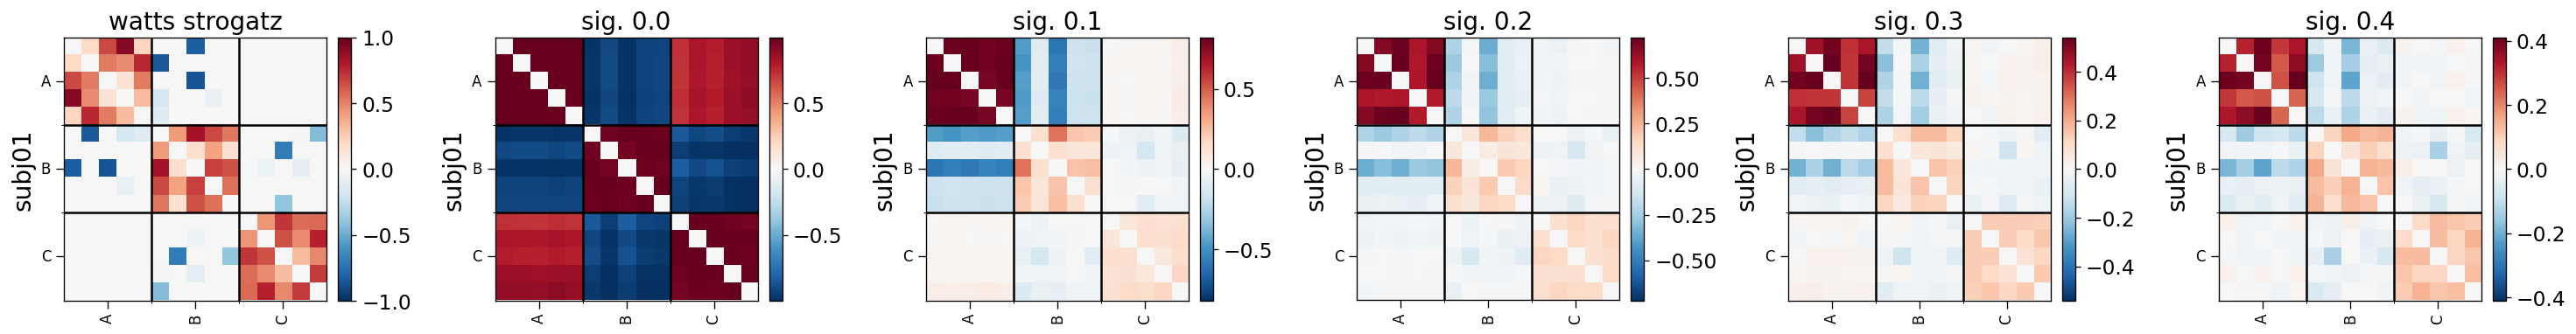

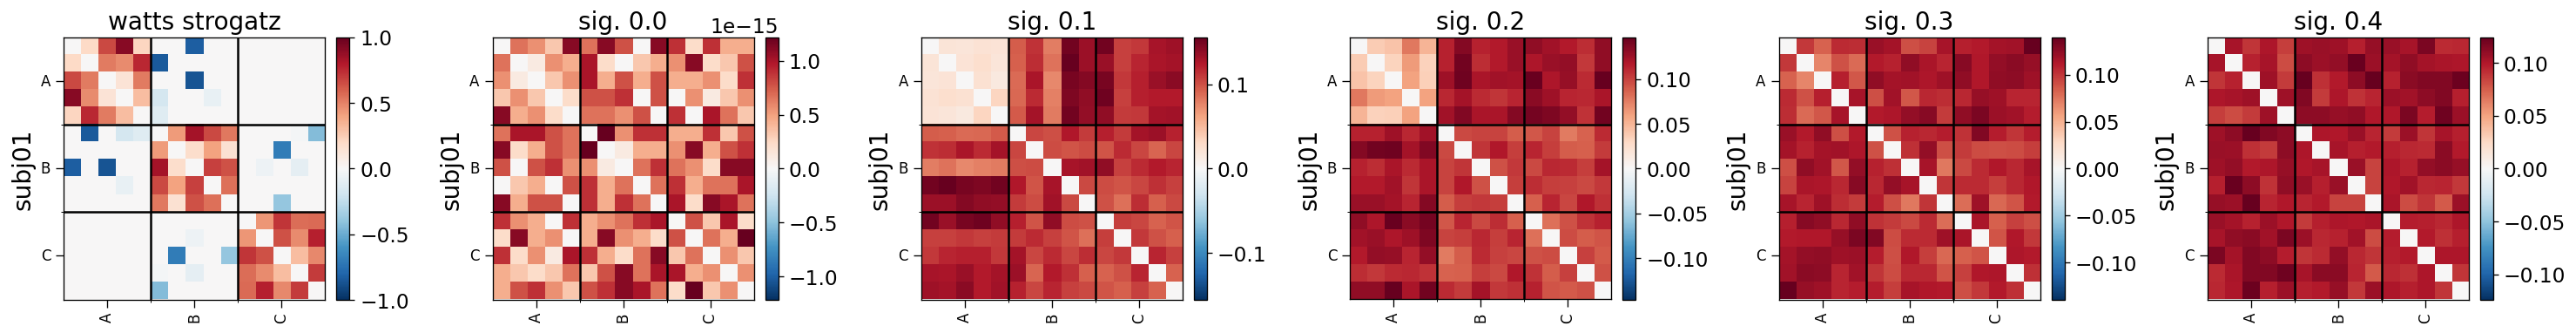

In [9]:
fcs = fc_utils.compute_fcs(args, out_dicts)
fcs_avg, fcs_std = fc_utils.get_average_fcs(args, fcs)
args.cmap = mpl.colormaps['RdBu_r'] #cmr.iceburn # mpl.colormaps['Oranges']
plot_utils.display_fcs(args, networks, fcs_avg)
plot_utils.display_fcs(args, networks, fcs_std)

## network inference: ARNI

100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


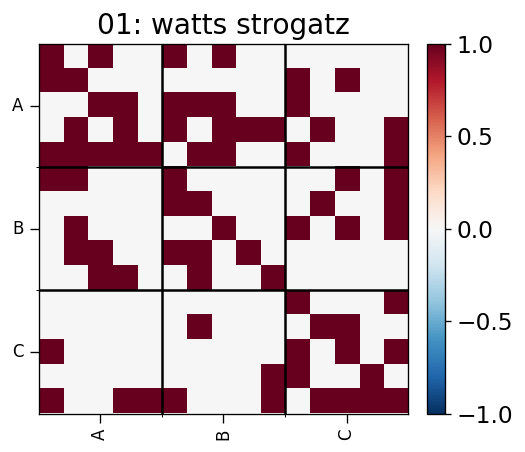

In [10]:
out_dict = out_dicts[f"subj{idx_subj:02}"][f"sigma{idx_sigma:02}"][f"run{8:02}"]
X = out_dict['x'].T

model, order, basis = 'a', 15, 'polynomial'
connectivity = networks[idx_subj]

reconstructions = arni.reconstruct(
    X=X, 
    model=model, order=order, basis=basis,
    connectivity=networks[idx_subj]
)
W_ = arni.get_inferred_network(args, reconstructions)
plot_utils.display_networks(args, [W_])